### Group Prject - London Bike Rentals

In this project, you will work with the London Bikes dataset, which records daily bike rentals in the city along with key variables such as dates, weather conditions, and seasonality.

The goal is to apply the full data analytics workflow:

- Clean and prepare the dataset.

- Explore the data through visualisation.

- Construct and interpret confidence intervals.

- Build a regression model to explain variation in bike rentals.

- By the end, you will connect statistical concepts with practical Python analysis.

In [55]:
## Import libraries and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

bikes = pd.read_csv('../../Data/london_bikes.csv')
bikes.head()

,date,bikes_hired,year,wday,month,week,cloud_cover,humidity,pressure,radiation,precipitation,snow_depth,sunshine,mean_temp,min_temp,max_temp,weekend
0,2010-07-30T00:00:00Z,6897,2010,Fri,Jul,30,6.0,65.0,10147.0,157.0,22.0,NaN,31.0,17.7,12.3,25.1,False
1,2010-07-31T00:00:00Z,5564,2010,Sat,Jul,30,5.0,70.0,10116.0,184.0,0.0,NaN,47.0,21.1,17.0,23.9,True
2,2010-08-01T00:00:00Z,4303,2010,Sun,Aug,30,7.0,63.0,10132.0,89.0,0.0,NaN,3.0,19.3,14.6,23.4,True
3,2010-08-02T00:00:00Z,6642,2010,Mon,Aug,31,7.0,59.0,10168.0,134.0,0.0,NaN,20.0,19.5,15.6,23.6,False
4,2010-08-03T00:00:00Z,7966,2010,Tue,Aug,31,5.0,66.0,10157.0,169.0,0.0,NaN,39.0,17.9,12.1,20.1,False


In [56]:
bikes.shape

(4934, 17)

In [57]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4934 entries, 0 to 4933
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4934 non-null   object 
 1   bikes_hired    4934 non-null   int64  
 2   year           4934 non-null   int64  
 3   wday           4934 non-null   object 
 4   month          4934 non-null   object 
 5   week           4934 non-null   int64  
 6   cloud_cover    4901 non-null   float64
 7   humidity       4851 non-null   float64
 8   pressure       4903 non-null   float64
 9   radiation      4894 non-null   float64
 10  precipitation  4903 non-null   float64
 11  snow_depth     4632 non-null   float64
 12  sunshine       4903 non-null   float64
 13  mean_temp      4903 non-null   float64
 14  min_temp       4872 non-null   float64
 15  max_temp       4903 non-null   float64
 16  weekend        4934 non-null   bool   
dtypes: bool(1), float64(10), int64(3), object(3)
memory 

**1. Data Cleaning**

Check for missing values across columns. How would you handle them?

Inspect the date column and ensure it is correctly formatted as datetime. Extract useful features (year, month, day, day of week, season).

Convert categorical variables (e.g., season, weather) to appropriate categories in Python.

Ensure numeric columns (e.g., bikes rented, temperature) are in the right format.

In [58]:
# Convert all columns that should be numeric to numeric, coercing errors to NaN
for col in bikes.select_dtypes(include=["number"]).columns.tolist():
    bikes[col] = pd.to_numeric(bikes[col], errors='coerce')

In [59]:
bikes.isna().any() # check if any column contains missing values

date             False
bikes_hired      False
year             False
wday             False
month            False
week             False
cloud_cover       True
humidity          True
pressure          True
radiation         True
precipitation     True
snow_depth        True
sunshine          True
mean_temp         True
min_temp          True
max_temp          True
weekend          False
dtype: bool

#### To the question: Check for missing values across columns. How would you handle them?

A/ 
- For numeric columns, We would fill the missing values with the mean
- For else, we would just drop them


In [60]:
df_mean = bikes.mean(numeric_only=True)
bikes_filled = bikes.fillna(df_mean)
bikes.dropna() # drop rows with any missing values (default)
bikes_filled.isna().any()

date             False
bikes_hired      False
year             False
wday             False
month            False
week             False
cloud_cover      False
humidity         False
pressure         False
radiation        False
precipitation    False
snow_depth       False
sunshine         False
mean_temp        False
min_temp         False
max_temp         False
weekend          False
dtype: bool

In [61]:
# Convert to datetime first
bikes['date'] = pd.to_datetime(bikes['date'])

# extract components
bikes["year"] = bikes["date"].dt.year
bikes["month"] = bikes["date"].dt.month
bikes["month_name"] = bikes["date"].dt.month_name()   # month label
bikes["day"] = bikes["date"].dt.day
bikes["day_of_week"] = bikes["date"].dt.day_name()     # weekday label
bikes['date'] = bikes['date'].dt.date


# create season_name based on numeric rules
bikes["season"] = np.select(
    [
        (bikes["month"].isin([12, 1, 2])),   # Winter: Dec, Jan, Feb
        (bikes["month"].isin([3, 4, 5])),    # Spring: Mar, Apr, May
        (bikes["month"].isin([6, 7, 8])),    # Summer: Jun, Jul, Aug
        (bikes["month"].isin([9, 10, 11]))   # Autumn: Sep, Oct, Nov
    ],
    ["Winter", "Spring", "Summer", "Autumn"], 
    default="Unknown"
)

# convert to ordered categorical, like fct_relevel in R
season_order = ["Winter", "Spring", "Summer", "Autumn"]
bikes["season"] = pd.Categorical(
    bikes["season"],
    categories=season_order,
    ordered=True
)

bikes.drop('wday', axis=1, inplace=True)
bikes.head()

,date,bikes_hired,year,month,week,cloud_cover,humidity,pressure,radiation,precipitation,snow_depth,sunshine,mean_temp,min_temp,max_temp,weekend,month_name,day,day_of_week,season
0,2010-07-30,6897,2010,7,30,6.0,65.0,10147.0,157.0,22.0,NaN,31.0,17.7,12.3,25.1,False,July,30,Friday,Summer
1,2010-07-31,5564,2010,7,30,5.0,70.0,10116.0,184.0,0.0,NaN,47.0,21.1,17.0,23.9,True,July,31,Saturday,Summer
2,2010-08-01,4303,2010,8,30,7.0,63.0,10132.0,89.0,0.0,NaN,3.0,19.3,14.6,23.4,True,August,1,Sunday,Summer
3,2010-08-02,6642,2010,8,31,7.0,59.0,10168.0,134.0,0.0,NaN,20.0,19.5,15.6,23.6,False,August,2,Monday,Summer
4,2010-08-03,7966,2010,8,31,5.0,66.0,10157.0,169.0,0.0,NaN,39.0,17.9,12.1,20.1,False,August,3,Tuesday,Summer


In [62]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4934 entries, 0 to 4933
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date           4934 non-null   object  
 1   bikes_hired    4934 non-null   int64   
 2   year           4934 non-null   int32   
 3   month          4934 non-null   int32   
 4   week           4934 non-null   int64   
 5   cloud_cover    4901 non-null   float64 
 6   humidity       4851 non-null   float64 
 7   pressure       4903 non-null   float64 
 8   radiation      4894 non-null   float64 
 9   precipitation  4903 non-null   float64 
 10  snow_depth     4632 non-null   float64 
 11  sunshine       4903 non-null   float64 
 12  mean_temp      4903 non-null   float64 
 13  min_temp       4872 non-null   float64 
 14  max_temp       4903 non-null   float64 
 15  weekend        4934 non-null   bool    
 16  month_name     4934 non-null   object  
 17  day            4934 non-null   in

**2. Exploratory Data Analysis (EDA)**

Plot the distribution of bikes rented.

Explore how rentals vary by season and month.

Investigate the relationship between temperature and bikes rented.

**Deliverables:**

At least 3 clear visualisations with captions.

A short written interpretation of key patterns (seasonality, weather effects, etc.).



### Plot the distribution of bikes rented.

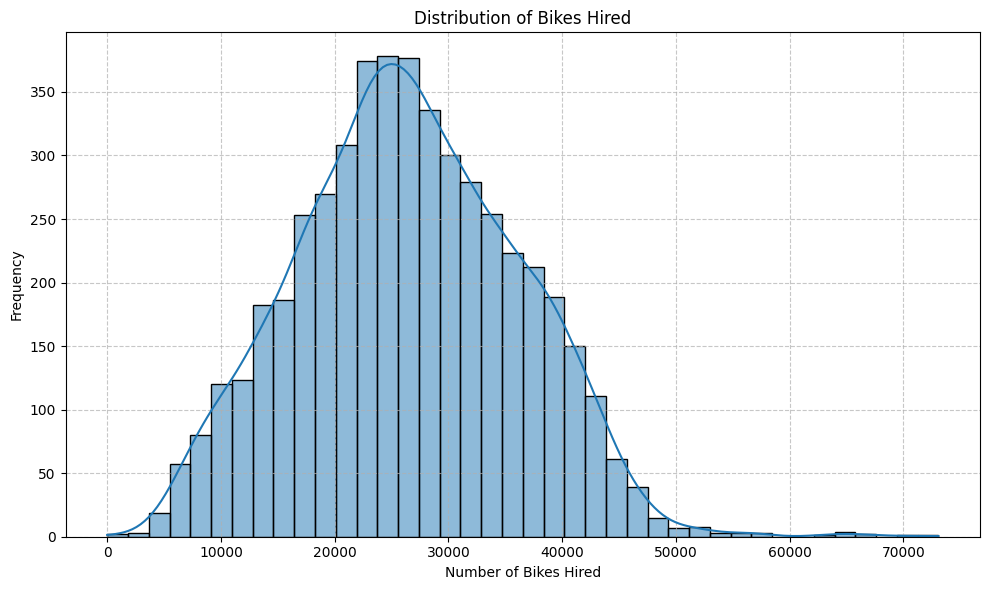

In [66]:
# Distribution of bikes_hired

plt.figure(figsize=(10, 6))
sns.histplot(data=bikes, x="bikes_hired", bins=40, kde=True)
plt.title("Distribution of Bikes Hired")
plt.xlabel("Number of Bikes Hired")
plt.ylabel("Frequency")
# plt.xticks(rotation=45)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Analysis:
1. Most bike hire days fall between 20k and 30k hires
2. The distribution of bikes rented is right-skewed, with most days having lower rentals and a few days with very high rentals.

### Explore how rentals vary by season and month.


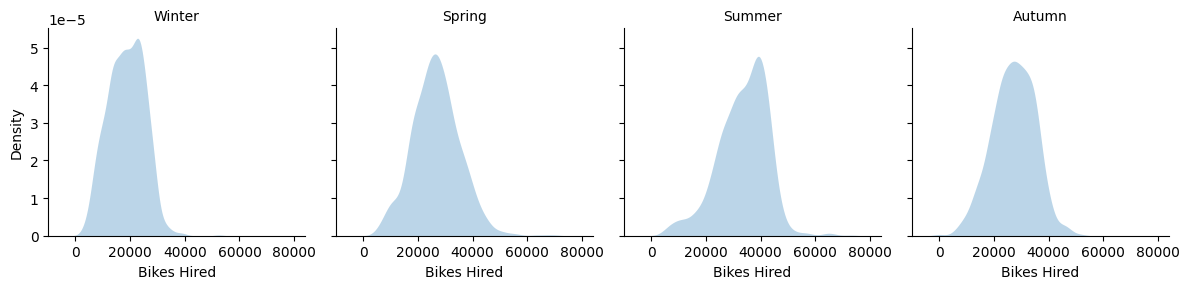

In [64]:
# Density plots of bikes hired by month and season
g = sns.FacetGrid(bikes, col="season", col_wrap=4, sharex=True, sharey=True)
g.map_dataframe(sns.kdeplot, x="bikes_hired", fill=True, alpha=0.3, linewidth=0)

# add titles and tidy style
g.set_axis_labels("Bikes Hired", "Density")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_25276\1426493120.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=bikes, x="season", y="bikes_hired", palette="Set2")


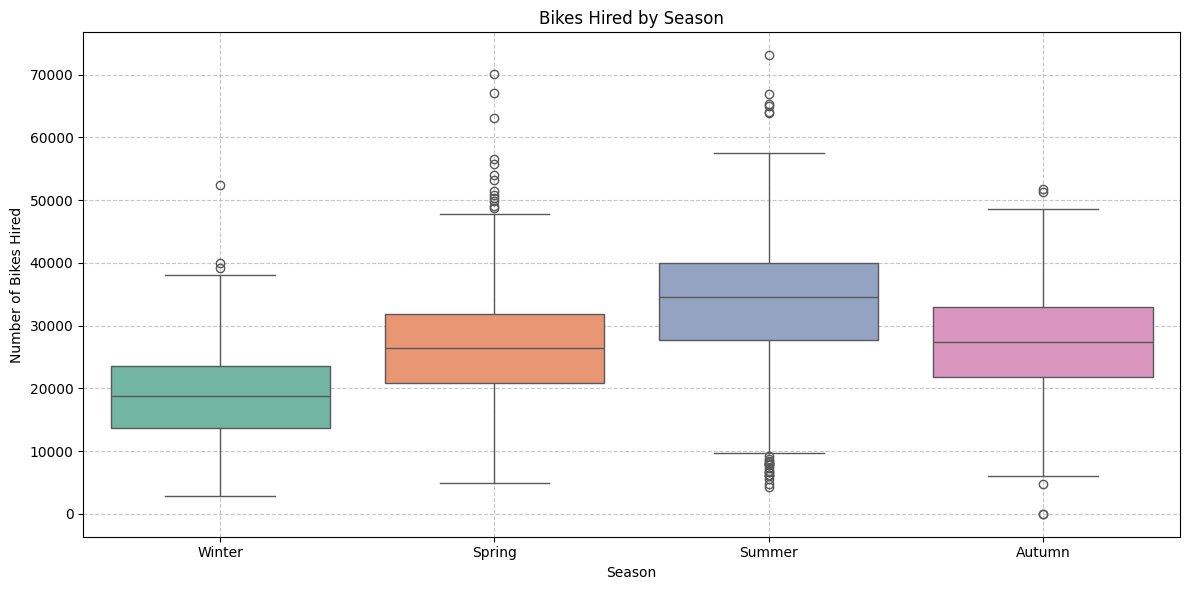

In [65]:
# Explore how rentals vary by season and month.
plt.figure(figsize=(12, 6))
sns.boxplot(data=bikes, x="season", y="bikes_hired", palette="Set2")
plt.title("Bikes Hired by Season")
plt.xlabel("Season")
plt.ylabel("Number of Bikes Hired")
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

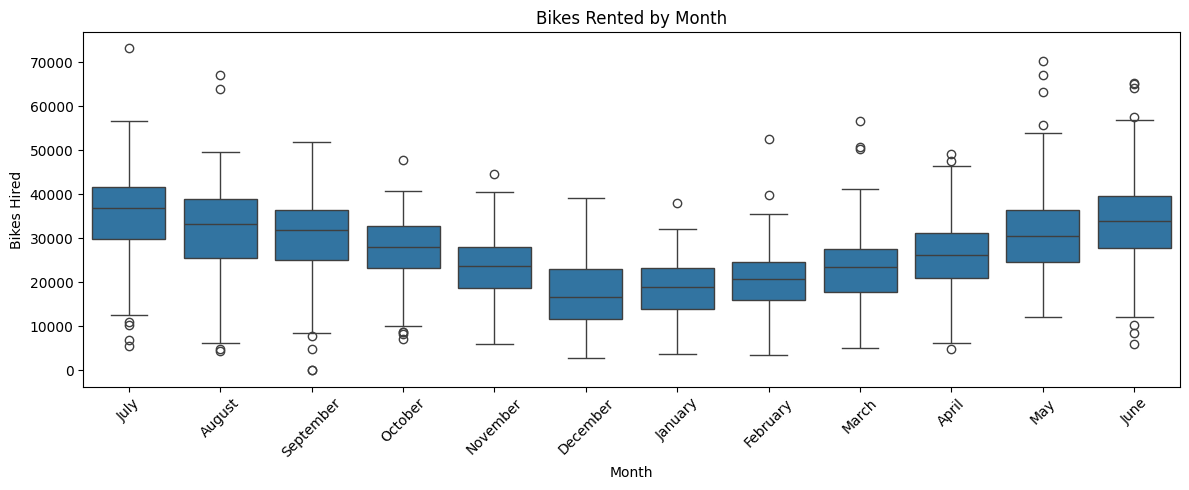

In [69]:
# Rentals by month
plt.figure(figsize=(12, 5))
month_order = bikes["month_name"].drop_duplicates().tolist()
sns.boxplot(data=bikes, x="month_name", y="bikes_hired", order=month_order)
plt.title("Bikes Rented by Month")
plt.xlabel("Month")
plt.ylabel("Bikes Hired")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Analysis
1. The graphs show that bike rentals are higher in warmer seasons (Spring and Summer) and months (May to September).
2. There are several outliers in the boxplots, especially in the warmer months and seasons, indicating some days with exceptionally high or exceptionally low bike rentals.

### Investigate the relationship between temperature and bikes rented.


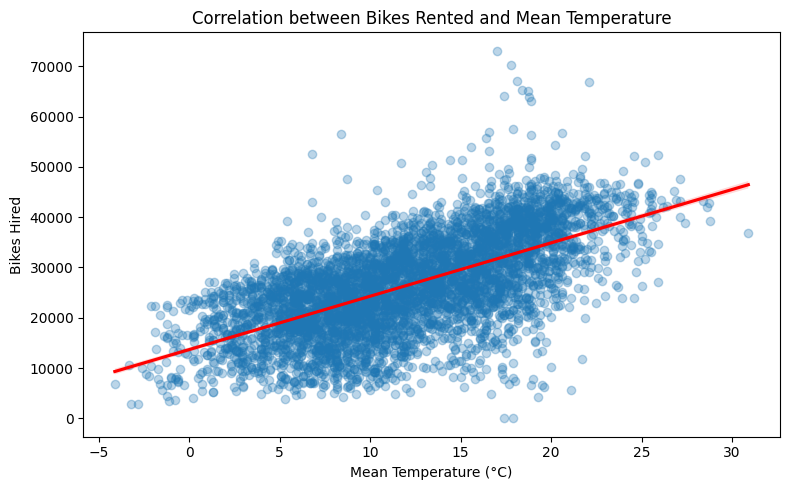

In [68]:
# Scatter plot with regression line to show correlation between bikes rented and mean temperature
plt.figure(figsize=(8, 5))
sns.regplot(data=bikes, x="mean_temp", y="bikes_hired", scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.xlabel("Mean Temperature (°C)")
plt.ylabel("Bikes Hired")
plt.title("Correlation between Bikes Rented and Mean Temperature")
plt.tight_layout()
plt.show()

#### Analysis:
1. There is a positive correlation between mean temperature and the number of bikes rented, indicating that as the temperature increases, bike rentals also tend to increase.

**3. Construct 95% confidence intervals for the mean number of bikes rented per season.**

Repeat the calculation per month.

Interpret the result:

What range of values do you expect the true mean to lie in?

Which seasons/months have higher or lower average demand?

Are there overlaps in the intervals, and what does that mean?

**Deliverables:**

A table or plot showing the mean and confidence intervals.

A short interpretation.

In [ ]:
## Your code goes here
#Overall information for all bikes hired
# Take the bikes_hired column (replace with actual column name)
bikes_hired = bikes["bikes_hired"].dropna()  # Remove any missing values from the bikes_hired column

# STEP 1: What you observe (Sample Statistics)
sample_mean = bikes_hired.mean()          # Calculate the sample mean (x̄)
sample_std = bikes_hired.std()            # Calculate the sample standard deviation (s)
n = len(bikes_hired)                      # Get the sample size (n)

# STEP 2: What you believe (Null Hypothesis)
mu_0 = 6000  # null hypothesis: H₀: μ = 7 (population mean equals 7)
          # Alternative hypothesis: H₁: μ ≠ 7 (two-sided test)

# STEP 3: Test statistic (t-statistic)
# Formula: t = (x̄ - μ₀) / (s / √n)
# This measures how many standard errors the sample mean is from the hypothesized mean
t_stat = (sample_mean - mu_0) / (sample_std / (n**0.5)) # n**0.5 means square root of n

# Degrees of freedom for t-distribution
df = n - 1  # df = sample size - 1

# STEP 4: Calculate p-value for two-sided test
# P-value = probability of observing a test statistic as extreme or more extreme
# For two-sided test: P(|T| >= |t_observed|) = 2 × P(T >= |t_observed|)
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df))

# Display results
print(f"Sample size: {n}")
print(f"Sample mean: {sample_mean:.3f}")
print(f"Test statistic (t): {t_stat:.3f}")
print(f"P-value: {p_value:.4f}")

# Interpretation:
# If p_value < 0.05: Reject H₀ (evidence against μ = 7)
# If p_value >= 0.05: Fail to reject H₀ (insufficient evidence against μ = 7)
# test statistic can be negative or positive depending on whether sample mean is less than or greater than mu_0


In [ ]:
#Bikes hired by season


In [ ]:
# 95% confidence intervals for mean bikes rented per season and per month

def mean_ci(series):
    n = series.count()
    mean = series.mean()
    std = series.std()
    se = std / np.sqrt(n)
    ci = stats.t.interval(0.95, n-1, loc=mean, scale=se)
    return pd.Series({'mean': mean, 'lower': ci[0], 'upper': ci[1], 'n': n})

# Per season
season_stats_long = bikes.groupby('season')['bikes_hired'].apply(mean_ci).reset_index()
# Pivot to wide format
season_stats = season_stats_long.pivot(index='season', columns='level_1', values='bikes_hired').reset_index()
print("Seasonal mean and 95% CI:")
print(season_stats)

# Per month
month_stats_long = bikes.groupby('month_name')['bikes_hired'].apply(mean_ci).reset_index()
# Pivot to wide format
month_stats = month_stats_long.pivot(index='month_name', columns='level_1', values='bikes_hired').reset_index()
# To order months correctly
month_stats['month_num'] = pd.to_datetime(month_stats['month_name'], format='%B').dt.month
month_stats = month_stats.sort_values('month_num')

print("\nMonthly mean and 95% CI:")
print(month_stats[['month_name', 'mean', 'lower', 'upper', 'n']])

# Plot: Mean and CI per season
plt.figure(figsize=(8, 5))
plt.errorbar(season_stats['season'], season_stats['mean'], 
             yerr=[season_stats['mean']-season_stats['lower'], season_stats['upper']-season_stats['mean']],
             fmt='o', capsize=5)
plt.title('Mean Bikes Hired per Season with 95% CI')
plt.ylabel('Mean Bikes Hired')
plt.xlabel('Season')
plt.tight_layout()
plt.show()

# Plot: Mean and CI per month
plt.figure(figsize=(10, 5))
plt.errorbar(month_stats['month_name'], month_stats['mean'], 
             yerr=[month_stats['mean']-month_stats['lower'], month_stats['upper']-month_stats['mean']],
             fmt='o', capsize=5)
plt.title('Mean Bikes Hired per Month with 95% CI')
plt.ylabel('Mean Bikes Hired')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Regression Analysis**

What variables influence the number of bikes rented (y) and how? Build a regression model that best explains the variability in bikes rented.

**Interpret:**

Which predictors are significant?

What do the coefficients mean (in practical terms)?

How much of the variation in bike rentals is explained (R²)?

**Deliverables:**

Regression output table.

A short discussion of which factors matter most for predicting bike rentals.

In [ ]:
#Your code goes here


## Deliverables
A knitted HTML, one person per group to submit